In [1]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [24]:
simrun=50#00
duration = 3500
#rm = 0.005
D=0.1

nproc=70
L=2#cbrt(10)
Nas = 5*L**3
k0= 0.1
method='multiprocessing'
Nb=1*L**3
print(Nas,Nb)
for rm in [0.05]:
    def write(name,obs):
        try:
            f=open(name,'w')
            data = np.array(obs.data()).T
            np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
            f.close()        
            print('saving into',name)        
            e=open(name+'_err','w')        
            err = np.array(obs.error()).T        
            np.savetxt(name+'_err',np.column_stack([err[0],err[1]]),delimiter=',',fmt='%s')
            e.close()
            print('saving into',name+'_err')
        except AttributeError:
            print('no error')

    def singlerun(solver='ode',intrinsic=False,simrun=1):   
        print(solver)
        V = L**3 
        M = max(int(min(cbrt(Nas), L / (2 * rm))), 3)
        if solver=='spa':
            solver=("spatiocyte",rm)
            V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)
        elif solver=='egfrd':
            solver = ('egfrd', Integer3(M, M, M)) 

        kon=k0/V        
        keff = kon*V/5/Nb
        kd = 4*np.pi*rm*2*D*2
        ka = keff*kd/(kd-keff)
        assert(ka>0)
        with species_attributes():
            A | {'D': D, 'radius':rm}
            B | {'D': D, 'radius':rm}

        with reaction_rules():
            ~A > A | kon
            A + B >B | (ka if intrinsic else keff)
        m = get_model()

        print('av={:.3},intrinsic={}'.format(float(V),intrinsic))
        print('kon={:.3},koff={:.3},kd={:.3},keff={:.3},kfactor={:.3}'.format(kon,(ka if intrinsic else keff),kd,keff,ka/kd))
        if simrun >1    :
            obs=ensemble.ensemble_simulations(duration,n=simrun, y0={'B':Nb},model=m, solver=solver,volume=ones()*L,species_list=["A"],return_type='observer',nproc=nproc,method=method)#,return_type="observer")
        else:
            obs=run_simulation(duration,model=m,y0={'B':Nb},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
        print('test')
        return obs

    obs1=singlerun('ode',False,1)
    obs2=singlerun('spa',True,simrun)
    #obs3=singlerun('egfrd',True,simrun)
    #obs4=singlerun('gillespie',False,simrun)
    #write('/home/chew/outputdata/sturrock_bd_ode_rm{:.3}_L2'.format(rm),obs1)
    #write('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_L2'.format(rm),obs2)
    #write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_L2'.format(rm),obs3)

40 8
ode
av=8.0,intrinsic=False
kon=0.0125,koff=0.0025,kd=0.251,keff=0.0025,kfactor=0.01
test
spa
av=9.71,intrinsic=True
kon=0.0103,koff=0.00253,kd=0.251,keff=0.0025,kfactor=0.01
test


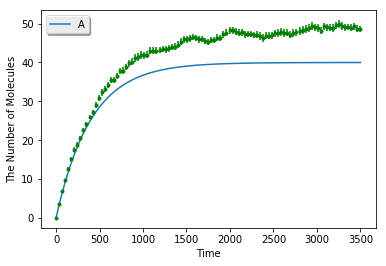

In [25]:
#viz.plot_number_observer(obs1,'r-',obs4,'k.')
#print(obs4.data().T[1][-1])
viz.plot_number_observer(obs1,'k-',obs2,'g.')


0.05
spa mean 4.0989215242


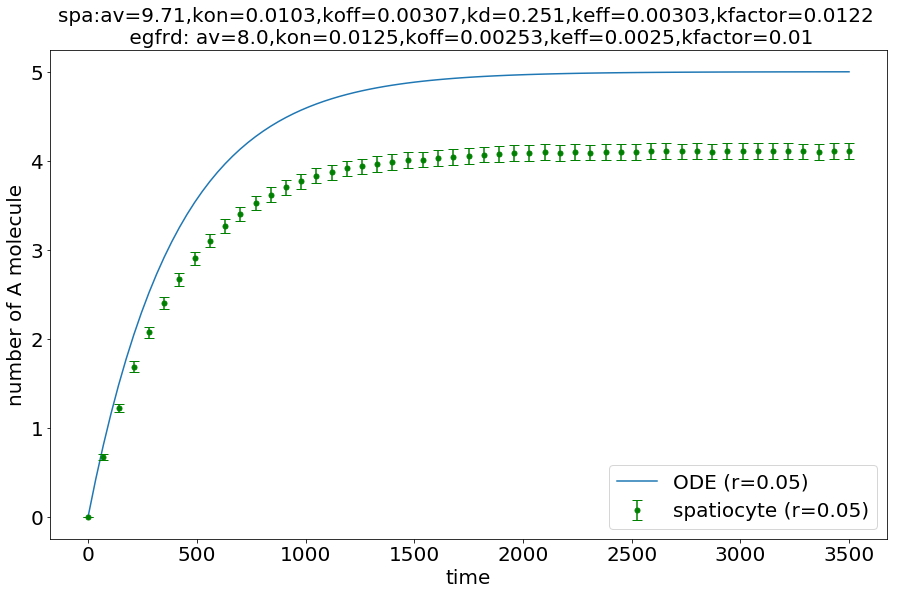

In [26]:
v=8.
avs=9.71

for rm in [0.05]:
    dat1=np.genfromtxt('/home/chew/outputdata/sturrock_bd_ode_rm{}_L2'.format(rm),delimiter=',',dtype='str')
    dat2=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm{}_L2'.format(rm),delimiter=',',dtype='str')
    err2=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm{}_L2_err'.format(rm),delimiter=',',dtype='str')
    #dat3=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{}_L2'.format(rm),delimiter=',',dtype='str')
    #err3=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{}_L2_err'.format(rm),delimiter=',',dtype='str')
    #dat4=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{}_largerBsmallerA'.format(rm),delimiter=',',dtype='str')
    fig=plt.figure()
    s1=[float(i) for i in dat2[:,0]]
    s2=[float(i)/avs for i in dat2[:,1]]
    err2=[float(i) for i in err2[:,1]]
    #e1=[float(i) for i in dat3[:,0]]
    #e2=[float(i) for i in dat3[:,1]]
    #err3=[float(i) for i in err3[:,1]]    
    plt.plot(dat1[:,0],[float(i)/v for i in dat1[:,1]], label='ODE (r={})'.format(rm))
    plt.errorbar(s1[::2], s2[::2], yerr=err2[::2], fmt='g.',capsize=5,markersize=10,label='spatiocyte (r={})'.format(rm))
    #plt.errorbar(e1[::2], e2[::2], yerr=err3[::2], fmt='r.',capsize=5,markersize=10,label='egfrd (r={})'.format(rm))
    #plt.plot(dat2[:,0],dat2[:,1],'.', markersize=10, label='spatiocyte (r={})'.format(rm))
    #plt.plot(dat3[:,0],dat3[:,1],'.',markersize=10,  label='egfrd (r={})'.format(rm))
    #plt.plot(dat4[:,0],dat4[:,1],'kx',markersize=10, label='egfrd (r={}) largeBsmallA'.format(rm))
    print(rm)
    print('spa mean',np.mean([float(i)/avs for i in dat2[:,1][-50:]]))
    #print('egfrd mean',np.mean([float(i) for i in dat3[:,1][-50:]]))
    plt.tick_params(labelsize=20)
    s=20
    plt.legend(loc='best',fontsize=20)
    plt.xlabel('time',fontsize=s)
    if rm==0.005:
        plt.title('spa:kon=0.0964,koff=0.119,kd=0.0251,keff=0.0207,kfactor=4.73 \n egfrdkon=0.1,koff=0.0979,kd=0.0251,keff=0.02,kfactor=3.9',fontsize=s)
    elif rm==0.05:
        #plt.title('kon=0.0601,koff=0.0383,kd=0.251,keff=0.0333,kfactor=0.153 \n kon=0.1,koff=0.0217,kd=0.251,keff=0.02,kfactor=0.0865',fontsize=s)
        plt.title('spa:av=9.71,kon=0.0103,koff=0.00307,kd=0.251,keff=0.00303,kfactor=0.0122 \n egfrd: av=8.0,kon=0.0125,koff=0.00253,keff=0.0025,kfactor=0.01',fontsize=s)
    plt.ylabel('number of A molecule',fontsize=s)
    fig.set_size_inches(15, 9)
    #plt.savefig('/home/chew/ecellwork/figure/sturrock_birth_death_rm{}_Nas5_10k.png'.format(rm))